<center><h1>Phishing Classificaiton</h1></center>

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from scipy import stats

In [27]:
df = pd.read_csv('parsed_url_features.csv')
# drop non numeric columns
for col in df.columns:
    if df[col].dtype == 'object':
        df = df.drop(col, axis=1)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(inplace=True)
df.head(10)

,status,n_period,n_hyphens,n_underscore,n_slash,n_questionmrk,n_equals,n_at,n_and,n_exclamation,url_length,domain_name_correct
0,0.0,2,0,0,3,0,0,0,0,0,25,1
1,0.0,2,1,0,3,0,0,0,0,0,35,1
2,0.0,2,1,0,0,0,0,0,0,0,35,1
3,0.0,1,0,0,0,0,0,0,0,0,9,0
4,0.0,3,0,0,10,1,0,0,0,0,74,0
5,0.0,3,2,0,0,0,0,0,0,0,36,0
6,0.0,3,0,0,7,0,0,0,0,0,54,0
7,0.0,2,1,1,7,0,0,0,0,0,74,1
8,0.0,5,2,0,3,0,0,0,0,0,50,1
9,0.0,4,0,0,0,0,0,0,0,0,21,1


In [28]:
# determimg the number of outliers
clf = IsolationForest(contamination=0.03)
X = df.iloc[:, 1:].dropna()
y_pred = clf.fit_predict(X)
outliers = np.where(y_pred==-1)
outliers = outliers[0]
print(outliers)
print('Number of outliers:', len(outliers))
print(df.shape)

[   12    46    53 ... 98212 98232 98561]
Number of outliers: 2958
(98572, 12)


In [29]:
outliers_exist = df.index.isin(outliers)
df_scaled = df[~outliers_exist]
print('Number of rows after dropping outliers:', df_scaled.shape[0])

Number of rows after dropping outliers: 95679


<h2>Splitting and Preprocessing the Data<h2>

In [30]:
y = df['status']
X = df.drop(columns=['status'])

# use kfold cross validation
kf = KFold(n_splits=5, shuffle=True)

In [31]:
scaler = StandardScaler()
fold_no = 1
for train, test, in kf.split(X, y):
    X = scaler.fit_transform(X)
    X_train, X_test = X[train], X[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    # train the model
    model = LocalOutlierFactor(n_neighbors=20, contamination=0.005, novelty=True)
    y_pred = model.fit(X_train, y_train)
    
    # evaluate the model
    score = model.score_samples(X_test)
    # find the mean of the score
    score = score.mean()
    print(f'Score for fold {fold_no}: {score*100}%')
    fold_no += 1

Score for fold 1: -654345469.1878606%
Score for fold 2: -468285787.6756711%
Score for fold 3: -1219728788.0430644%
Score for fold 4: -564524388.7874753%
Score for fold 5: -411329234.91376895%


In [32]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

logistic_model = LogisticRegression()

logistic_scores = cross_val_score(logistic_model, X, y, cv=kfold)

random_forest_model = RandomForestClassifier()

random_forest_scores = cross_val_score(random_forest_model, X, y, cv=kfold)

print(f'Logistic Regression scores: {logistic_scores}')
print(f'Random Forest scores: {random_forest_scores}')

Logistic Regression scores: [0.64630992 0.65112858 0.64345135 0.6493355  0.64705286]
Random Forest scores: [0.83357849 0.83119452 0.83042508 0.83007    0.83042508]


In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
logistic_accuracy = []
logistic_sensitivity = []
logistic_specificity = []
logistic_auc = []

random_forest_accuracy = []
random_forest_sensitivity = []
random_forest_specificity = []
random_forest_auc = []

fold_no = 1
for train, test in kf.split(X, y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    logistic_model.fit(X_train, y_train)
    logistic_y_pred = logistic_model.predict(X_test)
    
    logistic_accuracy.append(accuracy_score(y_test, logistic_y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, logistic_y_pred).ravel()
    logistic_sensitivity.append(tp / (tp + fn))
    logistic_specificity.append(tn / (tn + fp))
    logistic_auc.append(roc_auc_score(y_test, logistic_y_pred))
    
    random_forest_model.fit(X_train, y_train)
    random_forest_y_pred = random_forest_model.predict(X_test)
    
    random_forest_accuracy.append(accuracy_score(y_test, random_forest_y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, random_forest_y_pred).ravel()
    random_forest_sensitivity.append(tp / (tp + fn))
    random_forest_specificity.append(tn / (tn + fp))
    random_forest_auc.append(roc_auc_score(y_test, random_forest_y_pred))
    
    print(f"Metrics for fold {fold_no}:")
    print(f"Logistic Regression - Accuracy: {logistic_accuracy[-1]}, Sensitivity: {logistic_sensitivity[-1]}, Specificity: {logistic_specificity[-1]}, AUC: {logistic_auc[-1]}")
    print(f"Random Forest - Accuracy: {random_forest_accuracy[-1]}, Sensitivity: {random_forest_sensitivity[-1]}, Specificity: {random_forest_specificity[-1]}, AUC: {random_forest_auc[-1]}")
    print()
    
    fold_no += 1

print("Average Metrics:")
print(f"Logistic Regression - Accuracy: {sum(logistic_accuracy) / len(logistic_accuracy)}, Sensitivity: {sum(logistic_sensitivity) / len(logistic_sensitivity)}, Specificity: {sum(logistic_specificity) / len(logistic_specificity)}, AUC: {sum(logistic_auc) / len(logistic_auc)}")
print(f"Random Forest - Accuracy: {sum(random_forest_accuracy) / len(random_forest_accuracy)}, Sensitivity: {sum(random_forest_sensitivity) / len(random_forest_sensitivity)}, Specificity: {sum(random_forest_specificity) / len(random_forest_specificity)}, AUC: {sum(random_forest_auc) / len(random_forest_auc)}")

Metrics for fold 1:
Logistic Regression - Accuracy: 0.6438752219122496, Sensitivity: 0.6490524415922992, Specificity: 0.638575241223568, AUC: 0.6438138414079337
Random Forest - Accuracy: 0.830738016738524, Sensitivity: 0.8573147498245263, Specificity: 0.8035311024430302, AUC: 0.8304229261337781

Metrics for fold 2:
Logistic Regression - Accuracy: 0.648947501902105, Sensitivity: 0.6564459247648903, Specificity: 0.6408961817608079, AUC: 0.648671053262849
Random Forest - Accuracy: 0.8317017499365965, Sensitivity: 0.8578565830721003, Specificity: 0.8036183864520879, AUC: 0.8307374847620941

Metrics for fold 3:
Logistic Regression - Accuracy: 0.6455310946535457, Sensitivity: 0.6541368142114045, Specificity: 0.6363254593175853, AUC: 0.645231136764495
Random Forest - Accuracy: 0.827635183118596, Sensitivity: 0.8476788693689272, Specificity: 0.8061942257217848, AUC: 0.8269365475453561

Metrics for fold 4:
Logistic Regression - Accuracy: 0.6439586080957695, Sensitivity: 0.6544497417560587, Spec

In [34]:
metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [sum(logistic_accuracy) / len(logistic_accuracy), sum(random_forest_accuracy) / len(random_forest_accuracy)],
    'Sensitivity': [sum(logistic_sensitivity) / len(logistic_sensitivity), sum(random_forest_sensitivity) / len(random_forest_sensitivity)],
    'Specificity': [sum(logistic_specificity) / len(logistic_specificity), sum(random_forest_specificity) / len(random_forest_specificity)],
    'AUC': [sum(logistic_auc) / len(logistic_auc), sum(random_forest_auc) / len(random_forest_auc)]
})
metrics.head()

,Model,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.646979,0.655475,0.638039,0.646757
1,Random Forest,0.831169,0.854483,0.806676,0.830579


In [35]:
t_statistic, p_value = stats.ttest_rel(logistic_accuracy, random_forest_accuracy)
print(f'Accuracy: t-statistic = {t_statistic}, p-value = {p_value}')

t_statistic, p_value = stats.ttest_rel(logistic_sensitivity, random_forest_sensitivity)
print(f'Sensitivity: t-statistic = {t_statistic}, p-value = {p_value}')

t_statistic, p_value = stats.ttest_rel(logistic_auc, random_forest_auc)
print(f'AUC: t-statistic = {t_statistic}, p-value = {p_value}')

Accuracy: t-statistic = -117.74294890183398, p-value = 3.120346335231602e-08
Sensitivity: t-statistic = -64.40678864345423, p-value = 3.481184424509076e-07
AUC: t-statistic = -115.46115745760942, p-value = 3.3743526910344334e-08


In [41]:
# conduct t-tests for each feature
t_statistics = []
p_values = []
for col in df.columns[1:]:
    t_statistic, p_value = stats.ttest_rel(df[col], df['status'])
    t_statistics.append(t_statistic)
    p_values.append(p_value)
    
t_test_results = pd.DataFrame({ 'Feature': df.columns[1:], 'T-Statistic': t_statistics, 'P-Value': p_values })
t_test_results.head(15)

,Feature,T-Statistic,P-Value
0,n_period,299.328181,0.0
1,n_hyphens,68.579023,0.0
2,n_underscore,-55.995829,0.0
3,n_slash,324.403275,0.0
4,n_questionmrk,-136.647134,0.0
5,n_equals,-94.057516,0.0
6,n_at,-311.535731,0.0
7,n_and,-139.853987,0.0
8,n_exclamation,-320.477032,0.0
9,url_length,336.802030,0.0


In [42]:
# figure out what the best features are for each model, then print out the top 3 features
logistic_model.fit(X, y)
random_forest_model.fit(X, y)

rf_importances = random_forest_model.feature_importances_

lr_importances = np.abs(logistic_model.coef_)
feature_names = df.columns



print("Random Forest:")
for i in np.argsort(rf_importances)[::-1][:10]:
    print(f"{feature_names[i]}: {rf_importances[i]}")


Random Forest:
n_underscore: 0.3698655506121351
n_exclamation: 0.27327643715903627
status: 0.13863847603427187
n_period: 0.0969267986198499
n_hyphens: 0.05519385330636541
n_questionmrk: 0.02157125660159698
n_slash: 0.016305922352321926
url_length: 0.014467869494173
n_at: 0.009406429121145903
n_equals: 0.0038513272964187844


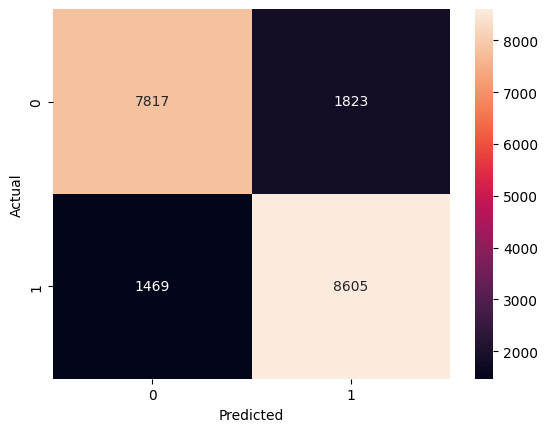

In [38]:
# Plot a heatmap of the confusion matrix for the random forest model
conf_matrix = confusion_matrix(y_test, random_forest_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()